<a href="https://colab.research.google.com/github/LucaSamore/Stroke-Prediction-Analysis/blob/main/stroke_prediction_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predizione di ictus in base ai dati di un paziente
**Progetto di Programmazione di Applicazioni Data Intensive a.a 2022/23**

Luca Samorè

luca.samore@studio.unibo.it

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Introduzione
Nel presente progetto vengono analizzati vari modelli di classificazione per prevedere quanto è probabile che un paziente venga colpito da un ictus. Il dataset, ottenuto da [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset), contiene oltre 5000 record di pazienti, alcuni dei quali sono stati colpiti da tale evento neurologico. L’obiettivo, dunque, è quello di prevedere una variabile discreta binaria.


In [2]:
dataset = pd.read_csv('healthcare-dataset-stroke-data.csv', sep=',')

## Analisi delle feature

In [3]:
dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


**Variabili categoriche**
- `gender`: sesso del paziente
  - "Male"
  - "Female"
  - "Other"
- `work_type`: tipologia di impiego del paziente
  - "children"
  - "Govt_jov"
  - "Never_worked"
  - "Private"
  - "Self-employed"
- `Residence_type`: tipologia di residenza del paziente
  - "Rural"
  - "Urban"
- `smoking_status`: stato di fumatore
  - "formerly smoked"
  - "never smoked"
  - "smokes"
  - "Unknown"
- `ever_married`: "Yes" se il paziente è mai stato sposato, "No" altrimenti
- `hypertension`: 1 se il paziente è affetto da ipertensione, 0 altrimenti
- `heart_disease`: 1 se il paziente ha complicanze cardiache, 0 altrimenti
- `stroke`: 1 se il paziente è stato colpito da ictus, 0 altrimenti

**Variabili numeriche**
- `id`: identificatore univoco del paziente
- `age`: età del paziente
- `avg_glucose_level`: livello medio di glucosio nel sangue
- `bmi`: indice di massa corporea

La variabile target è `stroke` che vale 1 se il paziente è stato colpito da ictus, 0 altrimenti.


In [4]:
dataset.info(memory_usage='deep');

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.8 MB


Siccome alcune variabili categoriche sono di tipo object (`gender`, `ever_married`, `work_type`, `Residence_type`, `smoking_status`) e intero (`hypertension`, `heart_disease`, `stroke`), per consumare meno memoria, ricarichiamo il dataset modificando il loro tipo come categorico.

In [5]:
categorical_features = [
    'gender',
    'hypertension',
    'heart_disease',
    'ever_married',
    'work_type',
    'Residence_type',
    'smoking_status',
    'stroke',
]

In [6]:
dataset = pd.read_csv(
    'healthcare-dataset-stroke-data.csv',
    sep=',',
    dtype={c: 'category' for c in categorical_features}
)

In [7]:
dataset.info(memory_usage='deep');

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 5110 non-null   int64   
 1   gender             5110 non-null   category
 2   age                5110 non-null   float64 
 3   hypertension       5110 non-null   category
 4   heart_disease      5110 non-null   category
 5   ever_married       5110 non-null   category
 6   work_type          5110 non-null   category
 7   Residence_type     5110 non-null   category
 8   avg_glucose_level  5110 non-null   float64 
 9   bmi                4909 non-null   float64 
 10  smoking_status     5110 non-null   category
 11  stroke             5110 non-null   category
dtypes: category(8), float64(3), int64(1)
memory usage: 201.9 KB


Notiamo che il consumo di memoria è stato ridotto significativamente.

La colonna `id` contiene un identificatore univoco per ogni paziente. Essa è irrilevante ai fini della predizione, perciò la possiamo eliminare o utilizzare come indice del dataframe. Procediamo con la seconda soluzione.

In [8]:
dataset.set_index('id', inplace=True)
dataset.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Analisi esplorativa e pulizia dei dati


Per ogni variabile numerica, visualizziamo alcune statistiche, come media, minimo, massimo, deviazione standard e percentili.

In [9]:
dataset.describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


Controlliamo se e quanto le due classi sono sbilanciate.

In [10]:
dataset['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

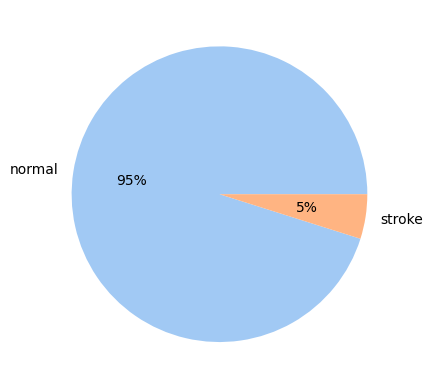

In [11]:
plt.pie(
    dataset['stroke'].value_counts(),
    labels=['normal', 'stroke'],
    colors=sns.color_palette('pastel'),
    autopct='%.0f%%'
);

Come potevamo aspettarci, le classi sono fortemente sbilanciate. Nella sezione successiva utilizzeremo delle tecniche apposite per affrontare questo problema.

Verifichiamo ora la presenza di valori nulli all’interno del dataset.

In [12]:
dataset.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Notiamo che sono presenti 201 istanze in cui la feature `bmi` è NaN.

In [13]:
dataset[dataset['bmi'].isna()]['stroke'].value_counts()

0    161
1     40
Name: stroke, dtype: int64

Tra queste 201 istanze, 161 sono pazienti che non sono stati colpiti da ictus, mentre le restanti 40 invece lo sono. Per non sbilanciare ulteriormente le classi, invece di eliminare le 201 istanze, riempiamo i valore nulli con la media della colonna `bmi`.

In [14]:
dataset.fillna(dataset['bmi'].mean(), inplace=True)
dataset.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Andiamo a visualizzare la distribuzione delle variabili continue del dataset, distinguendo le due categorie di pazienti.

In [15]:
numeric_features = [
    'age',
    'avg_glucose_level',
    'bmi',
]

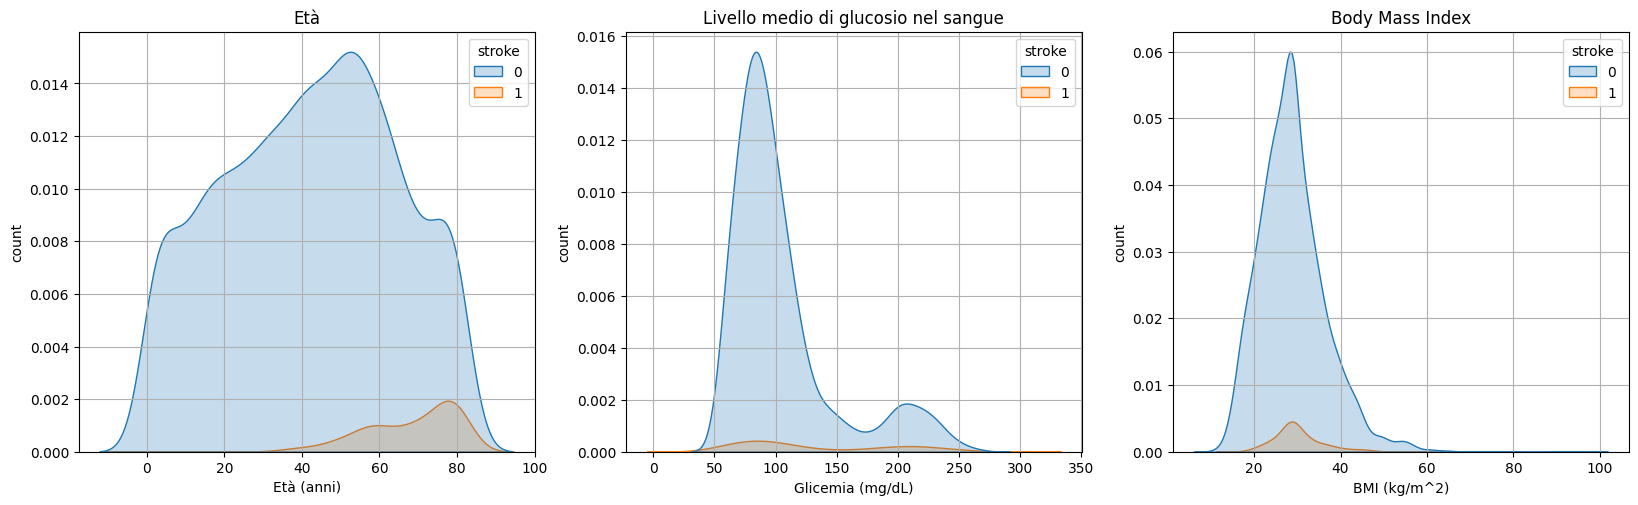

In [16]:
titles = [
    'Età',
    'Livello medio di glucosio nel sangue',
    'Body Mass Index',
]

xlabels = [
    'Età (anni)',
    'Glicemia (mg/dL)',
    'BMI (kg/m^2)',
]

plt.figure(figsize=(20, 12))

for i, feature in enumerate(numeric_features, start=1):
  plt.subplot(2, 3, i)
  plt.title(titles[i-1])
  sns.kdeplot(
    x=feature,
    hue='stroke',
    data=dataset,
    fill=True,
  )
  plt.grid()
  plt.ylabel('count')
  plt.xlabel(xlabels[i-1])

plt.show()

In generale, i pazienti che sono stati colpiti da ictus hanno un’età compresa tra i 40 e gli 80 anni, con la maggioranza dei pazienti colpiti intorno agli 80 anni.

Il livello di glucosio medio nel sangue si concentra per la maggior parte tra i 60 e i 120 $\frac{mg}{dL}$. Ma ci sono anche pazienti con un alto valore di glucosio, molti di questi colpiti da ictus.

La maggiornaza dei pazienti ha un indice di massa corporea tra i 20 e i 40 $\frac{kg}{m^2}$.

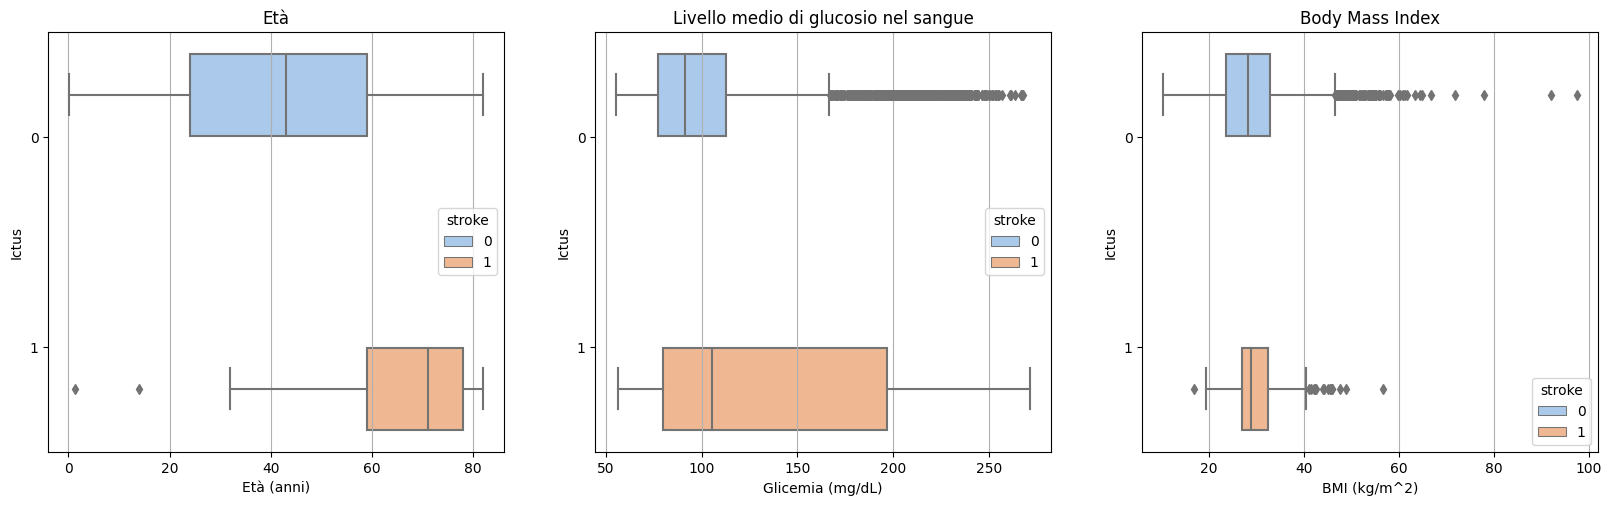

In [17]:
plt.figure(figsize=(20, 12))

for i, feature in enumerate(numeric_features, start=1):
  plt.subplot(2, 3, i)
  sns.boxplot(
    data=dataset,
    x=feature,
    y='stroke',
    hue='stroke',
    palette='pastel',
  )
  plt.title(titles[i-1])
  plt.xlabel(xlabels[i-1])
  plt.ylabel('Ictus')
  plt.grid(axis='x')

plt.show()

Notiamo che per le colonne `avg_glucose_level` e `bmi` sono presenti molti outliers.

Per quanto concerne l’indice glicemico, ipotizzando che le istanze con valore nell’intervallo 200-250 $\frac{mg}{dL}$ sono pazienti diabetici, decidiamo di mantenere le istanze. Per gli altri valori, cioè quelli intorno a 150 $\frac{mg}{dL}$, si ipotizza che siano relativi a misurazioni effettuate vicino ai pasti, più in generale a momenti in cui il paziente ha assunto una certa quantità di glucosio.

Per quanto riguarda l’indice di massa corporea, notiamo che sono presenti valori decisamente alti e altamente improbabili, in particolare quelli superiori ad 80. Decidiamo perciò di rimuovere tali istanze.

In [18]:
dataset.drop(dataset[dataset['bmi'] >= 60].index, inplace=True)
dataset['bmi'].describe()

count    5097.000000
mean       28.789649
std         7.404873
min        10.300000
25%        23.800000
50%        28.400000
75%        32.800000
max        59.700000
Name: bmi, dtype: float64

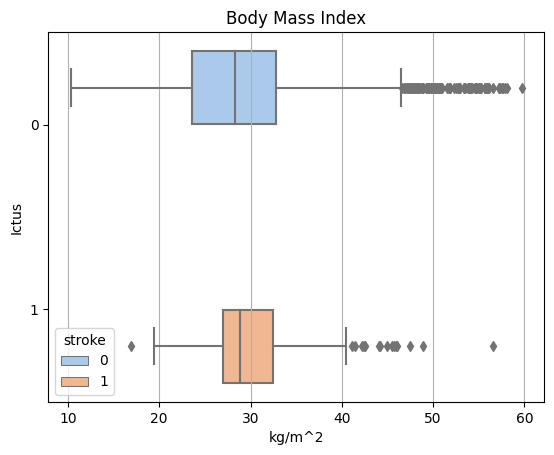

In [19]:
sns.boxplot(
  data=dataset,
  x='bmi',
  y='stroke',
  hue='stroke',
  palette='pastel',
)
plt.title('Body Mass Index')
plt.xlabel('kg/m^2')
plt.ylabel('Ictus')
plt.grid(axis='x')

In [20]:
categorical_features = [
    'gender',
    'hypertension',
    'heart_disease',
    'ever_married',
    'work_type',
    'Residence_type',
    'smoking_status',
]

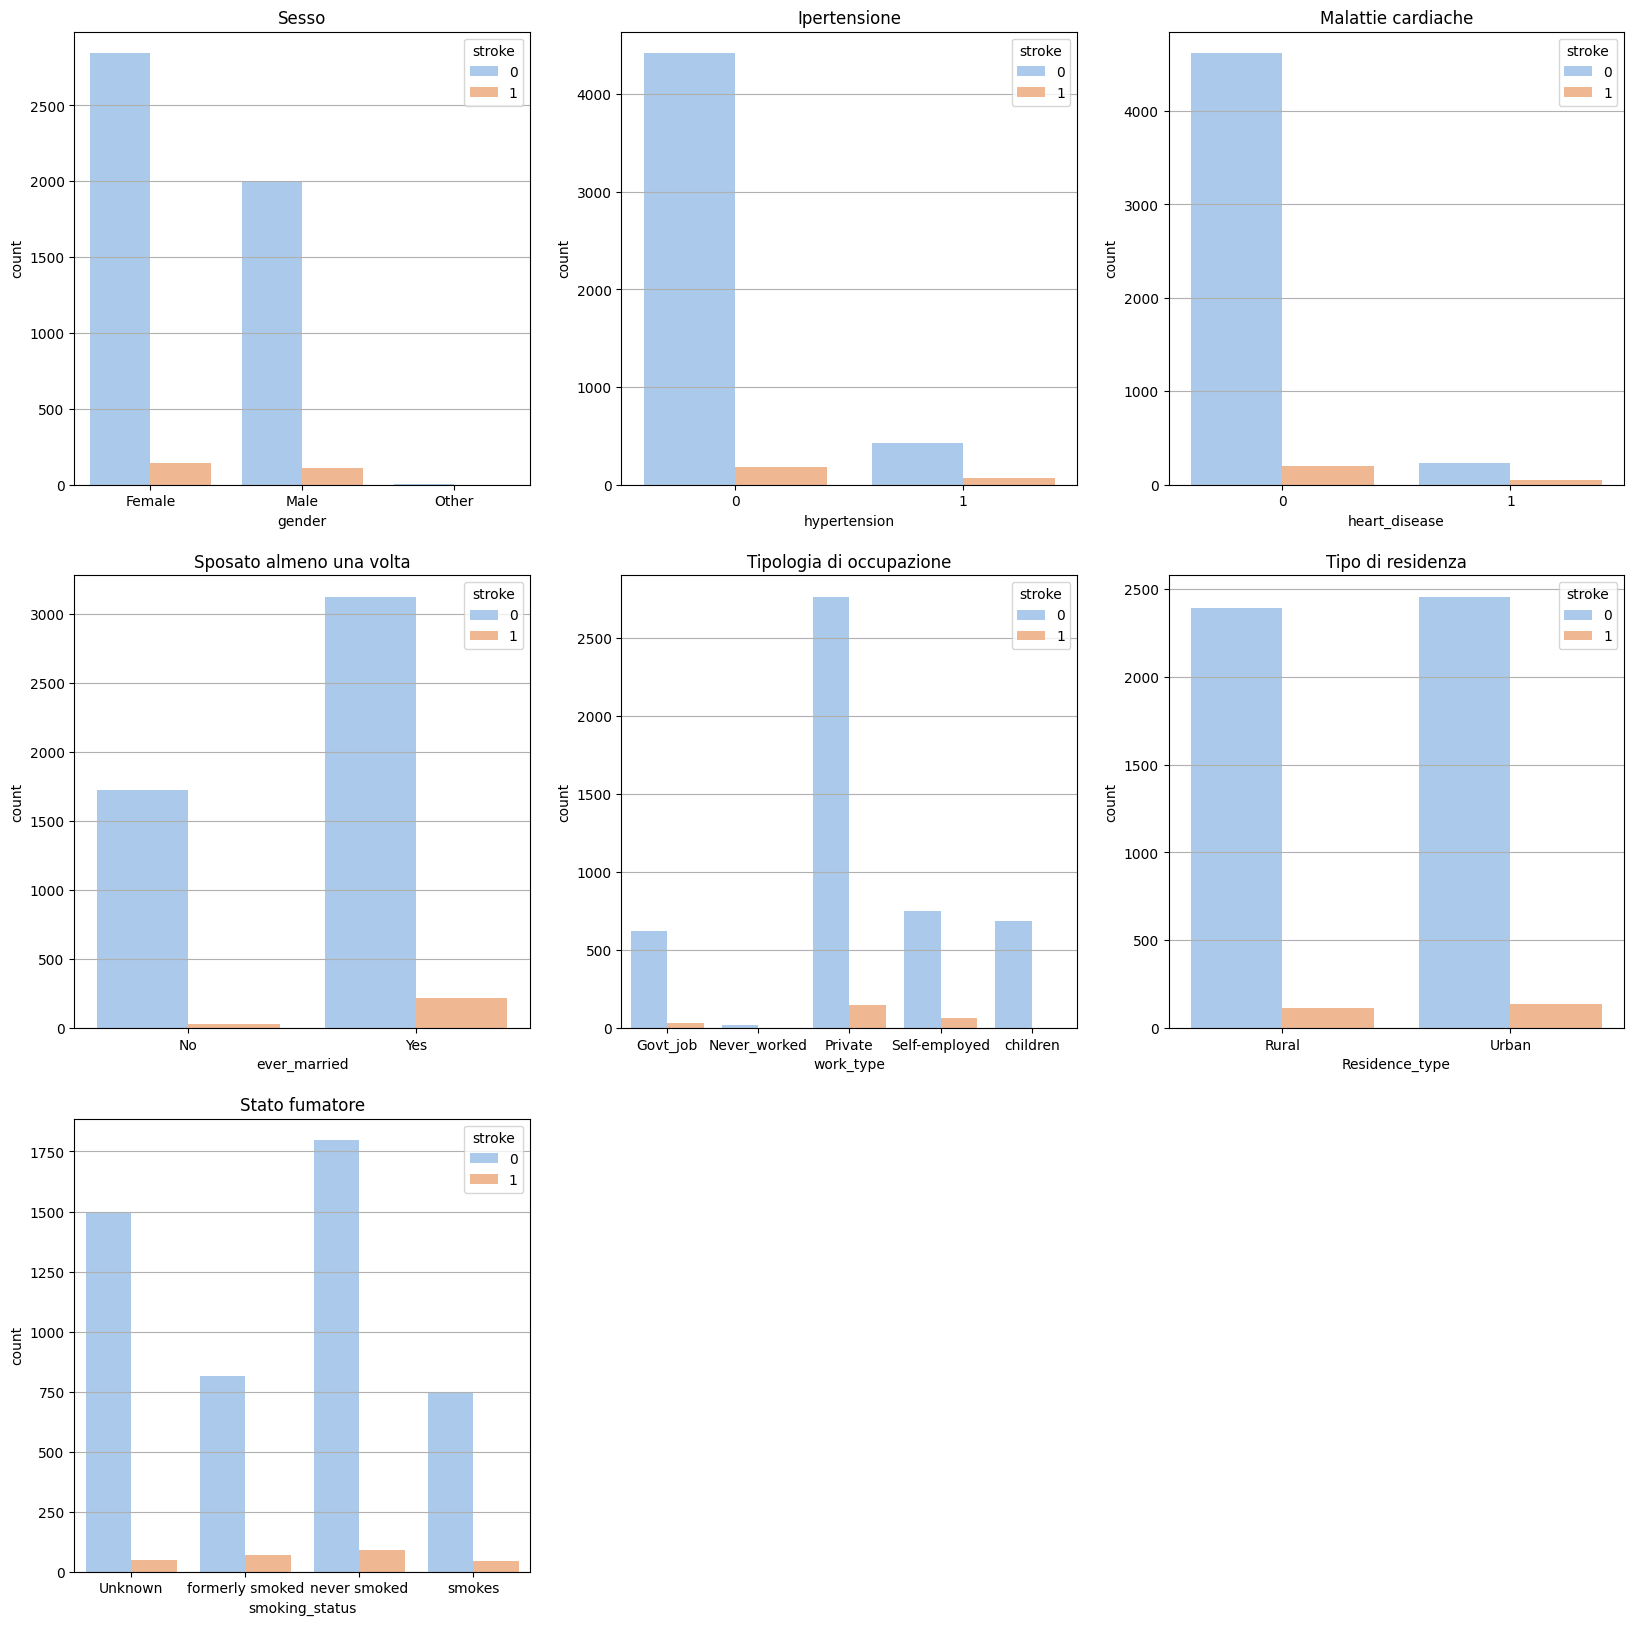

In [21]:
titles = [
    'Sesso',
    'Ipertensione',
    'Malattie cardiache',
    'Sposato almeno una volta',
    'Tipologia di occupazione',
    'Tipo di residenza',
    'Stato fumatore',
  ]

plt.figure(figsize=(20, 20))

for i, feature in enumerate(categorical_features, start=1):
  plt.subplot(3, 3, i)
  sns.countplot(
    data=dataset,
    x=feature,
    hue='stroke',
    palette='pastel',
  )
  plt.title(titles[i-1])
  plt.grid(axis='y')

plt.show()

Dal primo grafico notiamo che le donne sono leggermente meno soggette a ictus rispetto agli uomini. Pochissimi pazienti soffrono di ipertensione e di malattie cardiache. Circa due terzi dei pazienti presenti nel dataset si sono sposati almeno una volta. Quasi tutti i pazienti hanno un lavoro e sono tutti pressoché equamente distribuiti per quanto riguarda la loro residenza (urbana o rurale). Infine, è presente un elevato numero di pazienti di cui non si sa lo stato fumatore, ma ce ne sono tanti che non hanno mai fumato.

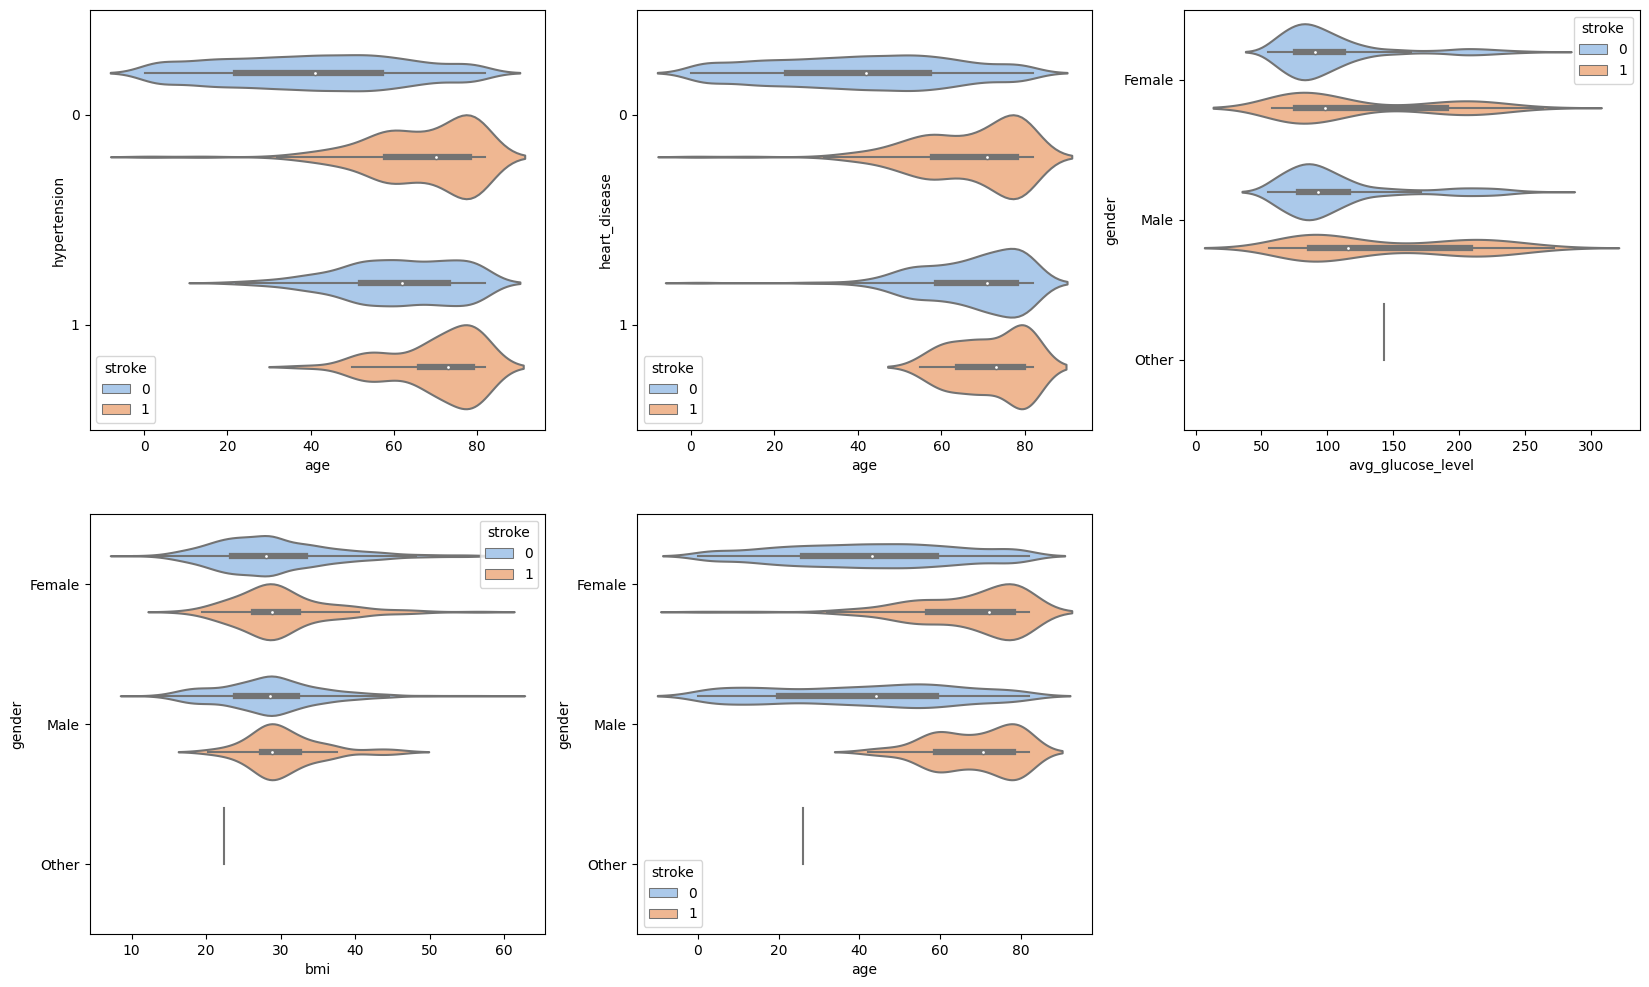

In [22]:
plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
sns.violinplot(data=dataset, x='age', y='hypertension', hue='stroke', palette='pastel')

plt.subplot(2, 3, 2)
sns.violinplot(data=dataset, x='age', y='heart_disease', hue='stroke', palette='pastel')

plt.subplot(2, 3, 3)
sns.violinplot(data=dataset, x='avg_glucose_level', y='gender', hue='stroke', palette='pastel')

plt.subplot(2, 3, 4)
sns.violinplot(data=dataset, x='bmi', y='gender', hue='stroke', palette='pastel')

plt.subplot(2, 3, 5)
sns.violinplot(data=dataset, x='age', y='gender', hue='stroke', palette='pastel')

plt.show();

<Axes: >

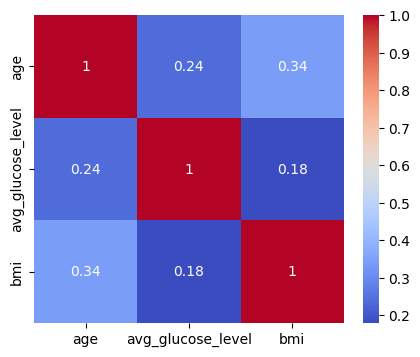

In [23]:
correlation_matrix = dataset.corr(method='pearson', numeric_only=True)
plt.figure(figsize=(5,4))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True)

Dalla matrice di correlazione si osserva che la correlazione di Pearson tra le variabili numeriche è molto bassa. Possiamo dunque mantenere tutte queste variabili quando andremo ad addestrare il modello.

## Preparazione dei dati

Isoliamo la variabile da predire dalle feature utilizzate per l’addestramento.

In [24]:
X = dataset.drop(columns=['stroke'])
X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked


In [25]:
y = dataset['stroke'].astype(int)
y.head()

id
9046     1
51676    1
31112    1
60182    1
1665     1
Name: stroke, dtype: int64

A questo punto, andiamo a suddividere il dataset in *training set* e *test set* utilizzando la funzione `train_test_split` di scikit-learn. Inoltre, specifichiamo come parametro nella funzione `stratify=y`, in modo tale da distribuire le istanze della variabile da predire nel training e nel test set.

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
  train_test_split(X, y, test_size=1/3, stratify=y, random_state=42)

Nella sezione precedente, abbiamo visto che le classi sono molto sbilanciate. Effettuiamo, dunque, un *oversampling* della classe meno rappresentata, i.e. `stroke=1`, tramite la tecnica SMOTE. In particolare, siccome il dataset contiene sia variabili numeriche e categoriche, utilizziamo una sua variante chiamata SMOTE-NC.

In [27]:
from imblearn.over_sampling import SMOTENC

smote_nc = \
  SMOTENC(categorical_features=[X_train.dtypes == 'category'], random_state=42)
X_train_resample, y_train_resample = smote_nc.fit_resample(X_train, y_train)

In [28]:
y_train_resample.describe()

count    6464.000000
mean        0.500000
std         0.500039
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
Name: stroke, dtype: float64

Notiamo che ora le classi sono perfettamente bilanciate.

A questo punto, effettuiamo il *one hot encoding* delle variabili categoriche.
Prima però, riconvertiamo le variabili binarie che erano categoriche in numeriche, perché altrimenti verrebbero generate variabili ridondanti che aggiungerebbero collinearità.

In [29]:
types = {'hypertension': int, 'heart_disease': int}

X_train_resample = X_train_resample.astype(types)
X_test = X_test.astype(types)

In [30]:
X_train_resample = pd.get_dummies(X_train_resample)
X_test = pd.get_dummies(X_test)

X_train_resample.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,47.00,0,0,131.43,24.3,1,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,70.00,1,0,242.52,45.5,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
2,27.00,0,0,75.04,24.5,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,22.00,0,0,56.84,29.9,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
4,1.32,0,0,67.68,16.5,1,0,0,1,0,...,0,0,0,1,1,0,1,0,0,0


## Modelli predittivi

Definiamo qualche funzione che ci tornerà utile per la valutazione dei modelli.

Iniziamo col definire una funzione che calcoli l’intervallo di confidenza, utile per confrontare i modelli analizzati.

In [31]:
from statsmodels.stats.proportion import proportion_confint

def confidence_interval(instance, acc, confidence):
    return proportion_confint(instance * acc, instance, 1-confidence/100, method='wilson')

Definiamo una funzione per stampare in formato tabellare la matrice di confusione.

In [32]:
from sklearn.metrics import confusion_matrix

labels = { 0: 'No Stroke', 1: 'Stroke' }

def print_confusion_matrix(model, y_test, y_pred, normalize=None):
  cm = pd.DataFrame(
      confusion_matrix(y_test, y_pred, normalize=normalize),
      index=model.classes_,
      columns=model.classes_,
  )
  cm.index = [labels[i] for i in cm.index]
  cm.columns = [labels[i] for i in cm.columns]
  return cm

Definiamo una funzione per la ricerca dei migliori iperparametri tramite *grid search*.

In [33]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

skf = StratifiedKFold(3, shuffle=True, random_state=42)

def grid_search(model, parameters, X, y, cv=None, scoring='accuracy'):
  gs = GridSearchCV(model, parameters, cv=skf if cv is None else cv, n_jobs=-1, scoring=scoring)
  gs.fit(X,y)
  print('Best parameters:', gs.best_params_)
  return gs

In [34]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

### Perceptron

In [35]:
from sklearn.linear_model import Perceptron

perceptron = Pipeline([
    ('scale', StandardScaler()),
    ('perceptron', Perceptron(random_state=42))
])

perceptron.fit(X_train_resample, y_train_resample)

print('Accuracy on training set {:.2f}%'.format(perceptron.score(X_train_resample, y_train_resample)*100))
print('Accuracy on test set {:.2f}%'.format(perceptron.score(X_test, y_test)*100))

Accuracy on training set 71.21%
Accuracy on test set 64.57%


In [36]:
y_pred = perceptron.predict(X_test)
print_confusion_matrix(perceptron, y_test, y_pred)

,No Stroke,Stroke
No Stroke,1031,585
Stroke,17,66


In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.64      0.77      1616
           1       0.10      0.80      0.18        83

    accuracy                           0.65      1699
   macro avg       0.54      0.72      0.48      1699
weighted avg       0.94      0.65      0.74      1699



In [38]:
perceptron = Pipeline([
    ('scaler', None),
    ('perceptron', Perceptron(random_state=42))
])

perceptron_parameters = [
  {
    'scaler': [None, StandardScaler(), MinMaxScaler()],
    'perceptron__penalty': ['l1', 'l2'],
    'perceptron__alpha': [0.0001, 0.001, 0.01, 1],
    'perceptron__fit_intercept': [False, True],
  },
  {
    'scaler': [None, StandardScaler(), MinMaxScaler()],
    'perceptron__penalty': ['elasticnet'],
    'perceptron__alpha': [0.0001, 0.001, 0.01, 1],
    'perceptron__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'perceptron__fit_intercept': [False, True],
  },
  {
    'scaler': [None, StandardScaler(), MinMaxScaler()],
    'perceptron__penalty': [None],
  },
]

gs = grid_search(perceptron, perceptron_parameters, X_train_resample, y_train_resample)
print('Best train score: {:.4f}%\nBest test score: {:.4f}%'.format(round(gs.best_score_ * 100, 4), round(gs.score(X_test, y_test)*100, 4)))

Best parameters: {'perceptron__alpha': 0.001, 'perceptron__fit_intercept': False, 'perceptron__l1_ratio': 0.9, 'perceptron__penalty': 'elasticnet', 'scaler': StandardScaler()}
Best train score: 76.9957%
Best test score: 72.3955%


Notiamo che la migliore combinazione utilizza la regolarizzazione `elasticnet` con `l1_ratio=0.9`, quindi molto vicina ad essere totalmente una regolarizzazione L1. Andiamo ad analizzare i coefficenti delle variabili.

In [39]:
pd.Series(gs.best_estimator_["perceptron"].coef_[0], X_train_resample.columns)

age                               2.369507
hypertension                      0.000000
heart_disease                     0.000000
avg_glucose_level                 3.177153
bmi                               0.000000
gender_Female                     0.820744
gender_Male                      -0.948369
gender_Other                      0.000000
ever_married_No                   0.000000
ever_married_Yes                  0.000000
work_type_Govt_job                0.000000
work_type_Never_worked            0.000000
work_type_Private                 0.000000
work_type_Self-employed           0.000000
work_type_children                0.000000
Residence_type_Rural              0.000000
Residence_type_Urban              0.000000
smoking_status_Unknown            0.000000
smoking_status_formerly smoked    0.000000
smoking_status_never smoked       0.000000
smoking_status_smokes             0.000000
dtype: float64

Osserviamo che le variabili `age`, `avg_glucose_level` e `gender_Female` sono quelle considerate dal modello, mentre le altre sono state annullate dalla regolarizzazione L1. Questo sembra ragionevole poiché la probabilità di essere colpito da un ictus dipende molto da queste variabili (in generale la probabilità per le donne è leggermente maggiore rispetto agli uomini).

In [40]:
y_pred = gs.predict(X_test)
print_confusion_matrix(gs, y_test, y_pred)

,No Stroke,Stroke
No Stroke,1170,446
Stroke,23,60


In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83      1616
           1       0.12      0.72      0.20        83

    accuracy                           0.72      1699
   macro avg       0.55      0.72      0.52      1699
weighted avg       0.94      0.72      0.80      1699



In [42]:
confidence = 95
lower, upper = confidence_interval(len(X_train), gs.score(X_test, y_test), confidence)

print('Interval with confidence {}%: \nPmin = {:.4f}%\nPmax = {:.4f}%'.format(confidence, lower*100, upper*100))

Interval with confidence 95%: 
Pmin = 70.8678%
Pmax = 73.8727%


### Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression

logistic_regression = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=42)),
])

logistic_regression.fit(X_train_resample, y_train_resample)

print('Accuracy on training set {:.2f}%'.format(logistic_regression.score(X_train_resample, y_train_resample)*100))
print('Accuracy on test set {:.2f}%'.format(logistic_regression.score(X_test, y_test)*100))

Accuracy on training set 79.75%
Accuracy on test set 73.81%


In [44]:
y_pred = logistic_regression.predict(X_test)
print_confusion_matrix(logistic_regression, y_test, y_pred)

,No Stroke,Stroke
No Stroke,1199,417
Stroke,28,55


In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1616
           1       0.12      0.66      0.20        83

    accuracy                           0.74      1699
   macro avg       0.55      0.70      0.52      1699
weighted avg       0.94      0.74      0.81      1699



In [46]:
logistic_regression = Pipeline([
    ('scaler', None),
    ('lr', LogisticRegression(random_state=42)),
])

logistic_regression_parameters = {
    'scaler': [None, StandardScaler(), MinMaxScaler()],
    'lr__penalty': ['l1', 'l2'],
    'lr__tol': [1e-9, 1e-6, 1e-3, 1e-2, 1e-1, 1],
    'lr__C': [1, 0.8, 0.3],
    'lr__solver': ['liblinear'],
}

gs = grid_search(logistic_regression, logistic_regression_parameters, X_train_resample, y_train_resample)

print('Best train score: {:.4f}%\nBest test score: {:.4f}%'.format(round(gs.best_score_ * 100, 4), round(gs.score(X_test, y_test)*100, 4)))

Best parameters: {'lr__C': 0.8, 'lr__penalty': 'l1', 'lr__solver': 'liblinear', 'lr__tol': 0.1, 'scaler': StandardScaler()}
Best train score: 79.8732%
Best test score: 73.2195%


Anche in questo caso, la combinazione migliore di parametri comprende la regolarizzazione L1. Andiamo a vedere i coefficienti delle variabili.

In [47]:
pd.Series(gs.best_estimator_["lr"].coef_[0], X_train_resample.columns)

age                               1.662397
hypertension                     -0.216857
heart_disease                    -0.264423
avg_glucose_level                 0.337544
bmi                              -0.116070
gender_Female                     0.035772
gender_Male                      -0.019373
gender_Other                     -0.005653
ever_married_No                  -0.465323
ever_married_Yes                  0.117931
work_type_Govt_job               -0.315145
work_type_Never_worked            0.010566
work_type_Private                 0.103010
work_type_Self-employed          -0.271002
work_type_children                0.286879
Residence_type_Rural              0.021925
Residence_type_Urban             -0.010392
smoking_status_Unknown           -0.044882
smoking_status_formerly smoked    0.101558
smoking_status_never smoked       0.060805
smoking_status_smokes             0.054426
dtype: float64

Questa volta notiamo che quasi tutte le variabili sono coinvolte.

In [48]:
y_pred = gs.predict(X_test)
print_confusion_matrix(gs, y_test, y_pred)

,No Stroke,Stroke
No Stroke,1187,429
Stroke,26,57


In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1616
           1       0.12      0.69      0.20        83

    accuracy                           0.73      1699
   macro avg       0.55      0.71      0.52      1699
weighted avg       0.94      0.73      0.81      1699



In [50]:
confidence = 95
lower, upper = confidence_interval(len(X_train), gs.score(X_test, y_test), confidence)

print('Interval with confidence {}%: \nPmin = {:.4f}%\nPmax = {:.4f}%'.format(confidence, lower*100, upper*100))

Interval with confidence 95%: 
Pmin = 71.7051%
Pmax = 74.6816%


### Random Forest

In [62]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = Pipeline([
    ('scaler', StandardScaler()),
    ('rfc', RandomForestClassifier(max_samples=0.2, n_jobs=-1, random_state=42)),
])

random_forest_classifier.fit(X_train_resample, y_train_resample)

print('Accuracy on training set {:.2f}%'.format(random_forest_classifier.score(X_train_resample, y_train_resample)*100))
print('Accuracy on test set {:.2f}%'.format(random_forest_classifier.score(X_test, y_test)*100))

Accuracy on training set 95.81%
Accuracy on test set 86.34%


In [52]:
y_pred = random_forest_classifier.predict(X_test)
print_confusion_matrix(random_forest_classifier, y_test, y_pred)

,No Stroke,Stroke
No Stroke,1436,180
Stroke,52,31


In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      1616
           1       0.15      0.37      0.21        83

    accuracy                           0.86      1699
   macro avg       0.56      0.63      0.57      1699
weighted avg       0.93      0.86      0.89      1699



In [63]:
random_forest_classifier = Pipeline([
    ('scaler', StandardScaler()),
    ('rfc', RandomForestClassifier(max_samples=0.2, n_jobs=-1, random_state=42)),
])

rfc_parameters = {
    'scaler': [None, StandardScaler()],
    'rfc__n_estimators': [100, 200, 300],
    'rfc__max_depth': [2, 4, 8, 16],
    'rfc__min_samples_leaf': [1, 2, 4],
    'rfc__min_samples_split': [2, 5, 10],
}

gs = grid_search(random_forest_classifier, rfc_parameters, X_train_resample, y_train_resample)

print('Best train score: {:.4f}%\nBest test score: {:.4f}%'.format(round(gs.best_score_ * 100, 4), round(gs.score(X_test, y_test)*100, 4)))

Best parameters: {'rfc__max_depth': 16, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 100, 'scaler': None}
Best train score: 90.7952%
Best test score: 85.8152%
